# VAE (Variational Auto Encoder)

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import torchvision
from torchvision import datasets
from torchvision import transforms as TVT

ハイパーパラメータ



In [2]:
input_dim = 784 # 画像データのサイズ(MNIST 28x28=784)
hidden_dim = 2000 # NNの中間層の次元サイズ
latent_dim = 20 # 潜在変数ベクトルzの次元数
epochs = 30
learning_rate = 3e-4
batch_size = 32

VAD エンコーダ

In [3]:
class VAE_Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 latent_dim, # 潜在変数zの次元数
                ):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim) # 分散varは, logvarとしてエンコーダに出力させる

    def forward(self, x):
        h = self.linear(x)
        f = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma

VAD デコーダ

In [4]:
class VAE_Decoder(nn.Module):
    def __init__(self,
                 latent_dim,
                 hidden_dim,
                 output_dim,
                ):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self,
                z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat

変数変換トリック
```
μ ----------------> (+) -----> z
                     ↑
σ --------> (・)------
              ↖
N(ε;,0,I)---->ε
```

In [5]:
def trick_of_latent_parameters(mu,sigma):
    # 標準正規分布 N(0,I)
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z

VAE

In [6]:
class VAE(nn.Module):
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 latent_dim,
                ):
        super().__init__()
        self.encoder = VAE_Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = VAE_Decoder(latent_dim, hidden_dim, input_dim)

    def loss(self, x):
        mu, sigma = self.encoder(x)
        z = trick_of_latent_parameters(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum') # MSE 二乗誤差
        L2 = - torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2) # KL情報量に関する誤差
        return (L1 + L2) / batch_size
        

学習と評価

In [7]:
import os
import sys
import shutil
from pathlib import Path

print(f"Current dir: {str(Path.cwd())}")

# データセット
transform = TVT.Compose([
    TVT.ToTensor(),
    TVT.Lambda(torch.flatten) # 画像をフラットに (28x28->784)
])
dataset = datasets.MNIST(
    root=str(os.sep.join([str(Path.cwd()), 'data'])),
    train=True,
    download=True, # False, 
    transform=transform,
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
)



Current dir: C:\Users\inoue\Documents\MyGithub\Book_ZeroDeepLearning6


In [8]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

True
1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU
(8, 6)


In [10]:
# モデルとオプティマイザ
model = VAE(input_dim, hidden_dim, latent_dim).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

# 学習ループ
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0
    for x, label in dataloader:
        x = x.to('cuda')
        label = label.to('cuda')
        optimizer.zero_grad()
        loss = model.loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.clone().to('cpu').item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(loss_avg)

45.80994160970052
42.356561228434245
41.68106889038086
41.334603493245446
41.03765588989258
40.93232452392578
40.74611032918294
40.53197057902018
40.320566943359374
40.14750644938151
39.997070513916015
39.87031340942383
39.77219496663412
39.715129091389976
39.58727537638347
39.57837646484375
39.49433490600586
39.450239329020185
39.35837211710612
39.30437239888509
39.28869775594075
39.23086252848307
39.1808764038086
39.19518920288086
39.14292319742839
39.10038984781901
39.06246931152344
39.06434857788086
39.05982467244466
38.99757546590169


画像生成

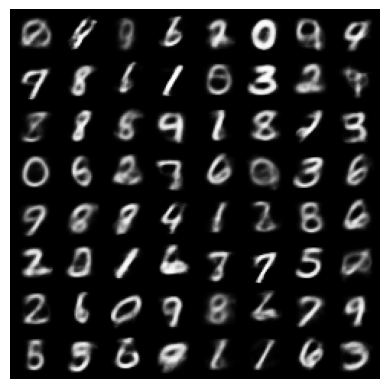

In [16]:
model = model.to('cpu')
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images,
    nrow=8,
    padding=2,
    normalize=True,
)

plt.imshow(grid_img.permute(1,2,0))
plt.axis('off')
plt.show()